## Importance Sampling - application to pricing of deep OTM options

@Author: Srijoy,
Copyright (C) [2019-21] by [Mr. Srijoy Das]

Permission is hereby granted, free of charge, to any person obtaining 
a copy of this software and associated documentation files (the "Software"), 
to deal in the Software without restriction, including without limitation
the rights to use, copy, modify, merge, publish, distribute, 
but not sell copies of the Software unless otherwise for training purposes only.

This implementation demonstrates the use of importance sampling as variance reduction technique in pricing of derivatives.

> **Problem: Suppose we wish to estimate the value of a call option using Monte Carlo methods which is well “out of the money”,  one with a strike price K far above the current price of the stock S0.**

>    - So that if we were to attempt to evaluate this option using crude Monte Carlo, the majority of the terminal stock price values randomly generated would fall below the strike (K) and contribute zero to the option price.
    - So the probability that S(T) > K can be very low, maybe less than 1%. This will contribute to higher standard error The estimator will only converge for large sample paths (M value) that is inefficient.
    - Solution: One possible remedy is to use importance sampling by adjusting the mean: mu = log(K/So), as demonstrated below.

**You will learn:**

- Implementation of Black-scholes option pricing model using simulation approach (using Monte Carlo) 
- Use of variance reduction technique such as Importance sampling in solving pricing issues related to deep OTM options
- Implementation of the importance sampling technique using scipy packages

## Packages ##

First, let's run the cell below to import all the packages that you will need during this assignment. 
- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a famous library to plot graphs in Python.
- Pandas is used to handle data manipulation in python.
- Scikit-learn is a free software machine learning library for the Python programming language. It features various classification, regression and clustering algorithms including support vector machines.
- SciPy contains modules for optimization, linear algebra, integration, interpolation.

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from scipy.stats import norm 
from scipy.optimize import minimize
import seaborn as sb

np.random.seed(1)

## 1 - Implementing the GBM model for pricing options using Monte Carlo## 

A stochastic process S is said to follow a GBM if it satisfies the following [[stochastic differential equation]] (SDE):

$ dS_t = \mu S_t\,dt + \sigma S_t\,dW_t $

where $ W_t $ is a [[Wiener process or Brownian motion]], and $ \mu $ ('the percentage drift') and $ \sigma $ ('the percentage volatility') are constants.

Consider the stochastic differential equation (Generalized form)

$\mathrm{d} X_t = a(X_t) \, \mathrm{d} t + b(X_t) \, \mathrm{d} W_t,$

with [[initial condition]] ''X''<sub>0</sub>&nbsp;=&nbsp;''x''<sub>0</sub>, where ''W''<sub>''t''</sub> stands for the [[Wiener process]], and suppose that we wish to solve this SDE on some interval of time [0,&nbsp;''T'']. Then the '''Euler–Maruyama approximation''' to the true solution ''X'' is defined as follows:

* partition the interval [0,&nbsp;''T''] into ''N'' equal subintervals of width $\Delta t>0$:
 $0 = \tau_{0} < \tau_{1} < \cdots < \tau_{N} = T \text{ and } \Delta t = T/N;$

* set Y<sub>0</sub>&nbsp;=&nbsp;X<sub>0</sub>;
* recursively define ''Y''<sub>''n''</sub> for 1&nbsp;≤&nbsp;''n''&nbsp;≤&nbsp;''N'' by

$\, Y_{n + 1} = Y_n + a(Y_n) \, \Delta t + b(Y_n) \, \Delta W_n,$

where W is the weiner process:

$\Delta W_n = W_{\tau_{n + 1}} - W_{\tau_n} = ~N(0,\Delta t)$, 
where N is Gaussian random variable.

The main steps of implementation are:
1. Define the functions (inputs, output/return values) 
2. Implement the euler discretisation algorithm for GBM model
3. Extracting stock prices data using pandas and calculating the mean and variance of the returns
4. Pricing the call option (under BS assumptions)

In [30]:
# MC simulation of GBM using Euler discretisation.
def GBM(So, mu, sigma, T, N, normal, num_sim):    
    
    dt = float(T/N)
    paths = np.zeros((num_sim, N+1))
    paths [:,0] = So
    for i in np.arange(1, int(N+1)):
        drift = (mu-0.5*sigma**2)*dt
        diffusion = sigma * np.sqrt(dt)
        paths[:,i] = paths[:,i-1] * np.exp(drift + diffusion*normal[:,i-1])

    return paths


def payoff(S_T, Strike, rate, Mat=1.0):
    payoff = np.exp(-rate*Mat) * max(S_T - Strike, 0)
    return payoff

def BSClosedForm(S0, K, r, T, sigma, is_call):
    # call or put
    d1 = ((r + 0.5 * sigma**2) * T + np.log(S0 /K )) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    p = 0.0
    
    if  is_call:
        p =  S0 * norm.cdf(d1) - np.exp(- r * T) *  K * norm.cdf(d2) 
    else:               
        p = np.exp(- r * T) *  K * norm.cdf(-d2) -  S0 * norm.cdf(-d1)
        
    return p

def daily_return(adj_close):
    returns = []
    for i in range(0, len(adj_close)-1):
        today = adj_close[i+1]
        yesterday = adj_close[i]
        daily_return = (today - yesterday)/yesterday
        returns.append(daily_return)
    return returns

In [31]:
panel_data = pd.read_csv('GOOG.csv', header=0, index_col=0)

adj_close = panel_data['Close']

returns = daily_return(adj_close)

#mu = np.mean(returns)*252.0          # drift coefficient
sig = np.std(returns)*np.sqrt(252.0)  # diffusion coefficient
#print (mu, sig)

So = adj_close[0]; 
Strike = 1.5*So # Moneyness
rate = 0.02
T = 1.0

print ('\nSpot price: %.2f and Strike: %0.2f' % (So, Strike))
price = BSClosedForm(So, Strike, rate, T, sig, True)
print('\nAnalytical price of OTM option is %.2f' %(price))


Spot price: 1035.61 and Strike: 1553.41

Analytical price of OTM option is 7.00


In [32]:
v1 = [];     
steps = 250; num_sim = 100;
normals = np.random.normal(0, 1, (num_sim, steps))
paths = GBM(So, rate, sig, T, steps, normals, num_sim)

for i in np.arange(num_sim):
    v1.append(payoff(paths[i,-1], Strike, rate, T))

price = np.mean(v1)
print ('\nMC price is: %.2f \n' % price)
mc_err = np.std(v1)/np.sqrt(num_sim)
print ('[Sampling err is: %.4f [N = %d]] \n' %(mc_err, num_sim))


MC price is: 12.51 

[Sampling err is: 5.5669 [N = 100]] 



## 2. Applying Importance sampling to the pricing ##

In Monte Carlo, much of the complexity in practice comes from trying to reduce the variance, to reduce the number of samples that have to be simulated to achieve a given accuracy. There are  various techniques used in practice to reduce variance such as: Antithetic variables, Control variates, <b>Importance sampling</b>, Low discrepancy sequences.

>- <b> Importance sampling </b> involves a change of probability measure that implies sampling from a different distribution than the distribution of interest to sample values that have more impact (“are important”) on the parameter being estimated.
    - In our example of deep OTM options, we therefore try to choose only important paths, that is, paths where the stock price is above K  at maturity.
    - Suppose p1(S) is the unconditional probability distribution function(pdf) for the stock price at maturity, then we have to choose a function p2(S) that allows us to sample more non-zero values.


MC price using Importance Sampling: 7.54 

[Sampling err is: 0.8616 [N = 100]] 



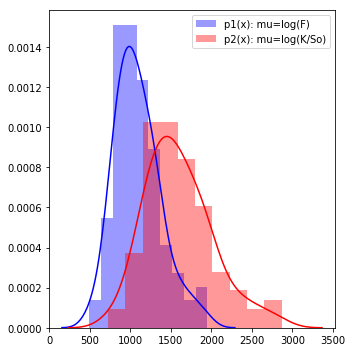

In [33]:
v1 = []
mu = np.log(Strike/So)
paths2 = GBM(So, mu, sig, T, steps, normals, num_sim)

for i in np.arange(num_sim):
    v1.append(payoff(paths2[i,-1], Strike, rate, T))

z = np.log(paths2[:,-1]/So)

#Lambd is the radon-nikodyn derivative
lambd = np.divide(norm.pdf(z, (rate - 0.5*(sig*sig))*T, sig*(T**0.5) ), \
            norm.pdf(z, (np.log(Strike/So) - 0.5*(sig*sig))*T, sig*(T**0.5) ))

v2 = np.multiply(v1, lambd)

price = np.mean(v2)
print ('\nMC price using Importance Sampling: %.2f \n' % price) 
mc_err = np.std(v2)/np.sqrt(num_sim)
print ('[Sampling err is: %.4f [N = %d]] \n' %(mc_err, num_sim))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
sb.distplot(paths[:,-1], label='p1(x): mu=log(F)', color='blue', ax=ax)
sb.distplot(paths2[:, -1], label='p2(x): mu=log(K/So)', color='red', ax=ax)
plt.legend()
plt.tight_layout()
plt.show()